#Intel Image Classification
## 1. Problem Difination
Image Scene Classification of Multiclass

## 2. Data
We have taken taken the data from kaggle:-https://www.kaggle.com/datasets/puneet6060/intel-image-classification

## 3. Evaluation
The evaluation is a file with prediction probabilities for each  test images.https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test

## 4. Features
This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.


In [1]:
## Importing riquired libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Activation , GlobalAvgPool2D , Dense , Flatten , BatchNormalization , Conv2D , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation , RandomFlip


In [2]:
# !pip install kaggle
# from google.colab import drive
# drive.mount('/content/drive')


## unziping the data
using 

`!unzip "path"`

In [3]:
# !unzip "/content/drive/MyDrive/intel image classification.zip" -d "drive/MyDrive/intel image"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## loading data 


In [5]:
# importing Data sets

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Directory paths for train, validation, and test data
train_dir = '/content/drive/MyDrive/intel image/seg_train/seg_train'
test_dir = '/content/drive/MyDrive/intel image/seg_pred'
val_dir = '/content/drive/MyDrive/intel image/seg_test/seg_test'

# Create a training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical")

# Create a validation dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

# Create a test dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, 
    label_mode="categorical")



Found 14034 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.
Found 3000 files belonging to 6 classes.


## Visualising data 

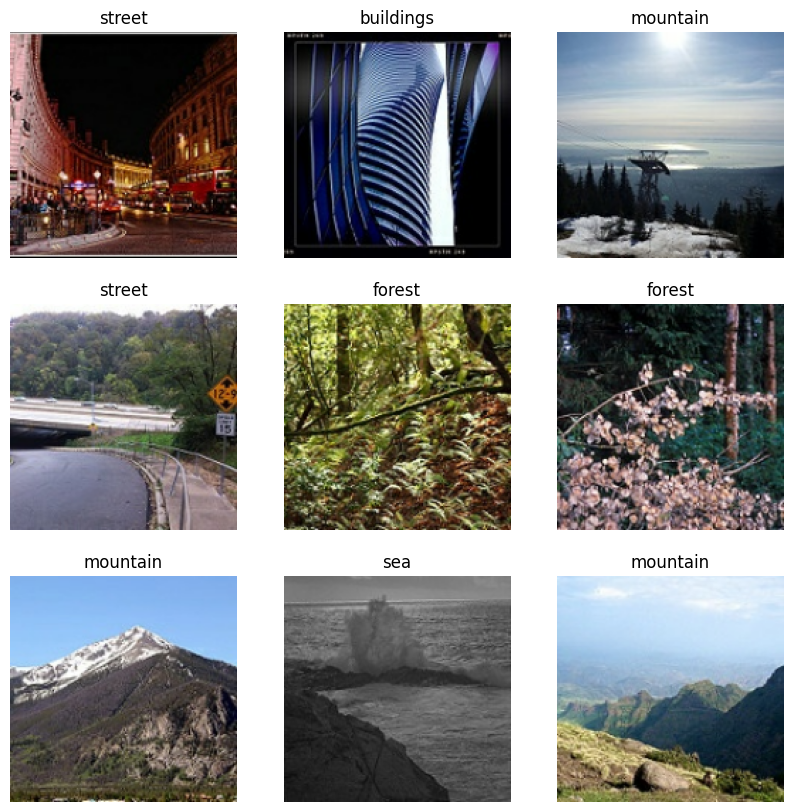

In [6]:
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for image , labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [7]:
# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
# Callbacks
Checkpoint_path="/content/drive/MyDrive/intel image/mobilenetv2.h5"
Checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(Checkpoint_path ,monitor="val_accuracy" ,verbose=1 , save_best_model=True , save_weights_only=True)

In [9]:
Earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta = 0.001 , patience=3)

In [10]:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",verbose =1)

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:

# Define the input shape for the model
IMG_SHAPE = IMG_SIZE + (3,)

# Load the pre-trained MobileNetV2 model from Keras
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=True,
    weights='imagenet'
)

# Print the model summary
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
image_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
label_batch

<tf.Tensor: shape=(32, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.,

In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n09193705', 'alp', 0.5555776), ('n09468604', 'valley', 0.21258129)],
 [('n03028079', 'church', 0.34459203), ('n03781244', 'monastery', 0.21366945)],
 [('n09193705', 'alp', 0.7316849), ('n09468604', 'valley', 0.10602127)],
 [('n09193705', 'alp', 0.35203484), ('n09468604', 'valley', 0.22273967)],
 [('n09472597', 'volcano', 0.28059208), ('n09193705', 'alp', 0.2736157)],
 [('n03216828', 'dock', 0.44241548),
  ('n04311004', 'steel_arch_bridge', 0.12190304)],
 [('n09193705', 'alp', 0.7904678), ('n04228054', 'ski', 0.048730273)],
 [('n09193705', 'alp', 0.8413264), ('n09468604', 'valley', 0.12518337)],
 [('n09193705', 'alp', 0.8635177), ('n09468604', 'valley', 0.014623056)],
 [('n04604644', 'worm_fence', 0.26721945),
  ('n13052670', 'hen-of-the-woods', 0.100765854)],
 [('n09332890', 'lakeside', 0.7564196), ('n09428293', 'seashore', 0.1290175)],
 [('n09193705', 'alp', 0.6127391), ('n09468604', 'valley', 0.1652769)],
 [('n04612504', 'yawl', 0.35582998), ('n04483307', 'trimaran', 0.27636734)]

In [16]:
def model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet") # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAvgPool2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)    
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(6,activation="softmax")(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [17]:
model2 = model(IMG_SIZE)

In [18]:
base_learning_rate = 0.001
model2.compile(optimizer="sgd",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
history = model2.fit(train_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 5 ,
                    verbose =1,
                    validation_data = val_dataset,
                    validation_steps=len(val_dataset),
                    callbacks=[Checkpoint_callback , Earlystopping_callback , learning_rate_callback])

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.8344
Epoch 1: saving model to /content/drive/MyDrive/intel image/mobilenetv2.h5
439/439 [==============================] - 320s 720ms/step - loss: 0.4559 - accuracy: 0.8344 - val_loss: 0.2861 - val_accuracy: 0.9047 - lr: 0.0100
Epoch 2/5
438/439 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.8952
Epoch 2: saving model to /content/drive/MyDrive/intel image/mobilenetv2.h5
439/439 [==============================] - 33s 74ms/step - loss: 0.3046 - accuracy: 0.8952 - val_loss: 0.2639 - val_accuracy: 0.9113 - lr: 0.0100
Epoch 3/5
437/439 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.9039
Epoch 3: saving model to /content/drive/MyDrive/intel image/mobilenetv2.h5
439/439 [==============================] - 33s 74ms/step - loss: 0.2715 - accuracy: 0.9037 - val_loss: 0.2504 - val_accuracy: 0.9130 - lr: 0.0100
Epoch 4/5
438/439 [============================>.]

In [22]:
from tensorflow.keras.models import load_model

# Save the model
model2.save("intel_image_classification_model_transfer_learning.h5")


In [23]:
model2 = load_model("intel_image_classification_model_transfer_learning.h5")

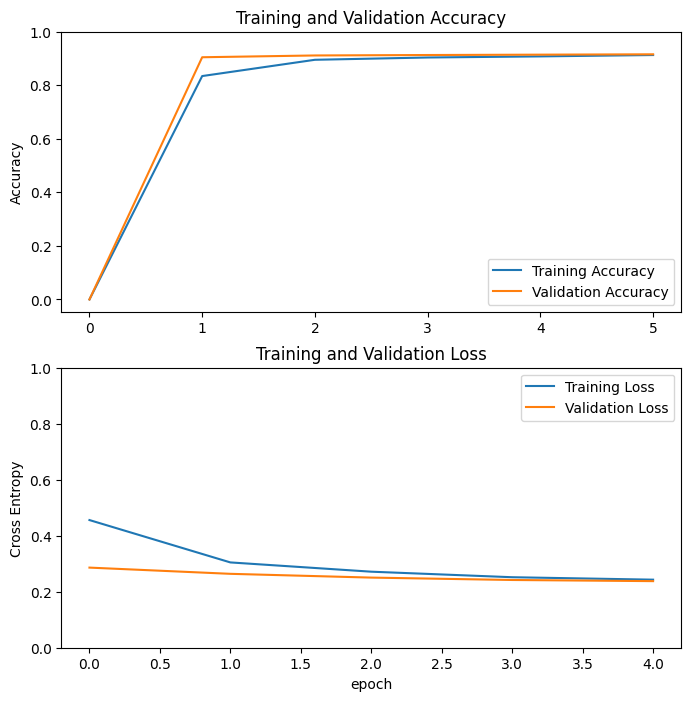

In [24]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
base_model = model2
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 7

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits= True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  8


In [60]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/10
439/439 [==============================] - 33s 75ms/step - loss: 0.1730 - accuracy: 0.9354 - val_loss: 0.2259 - val_accuracy: 0.9193
Epoch 6/10
439/439 [==============================] - 32s 71ms/step - loss: 0.1684 - accuracy: 0.9357 - val_loss: 0.2263 - val_accuracy: 0.9197
Epoch 7/10
439/439 [==============================] - 37s 83ms/step - loss: 0.1687 - accuracy: 0.9376 - val_loss: 0.2260 - val_accuracy: 0.9197
Epoch 8/10
439/439 [==============================] - 32s 71ms/step - loss: 0.1669 - accuracy: 0.9367 - val_loss: 0.2254 - val_accuracy: 0.9197
Epoch 9/10
439/439 [==============================] - 33s 75ms/step - loss: 0.1635 - accuracy: 0.9414 - val_loss: 0.2257 - val_accuracy: 0.9197
Epoch 10/10
439/439 [==============================] - 31s 71ms/step - loss: 0.1640 - accuracy: 0.9382 - val_loss: 0.2257 - val_accuracy: 0.9193


In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

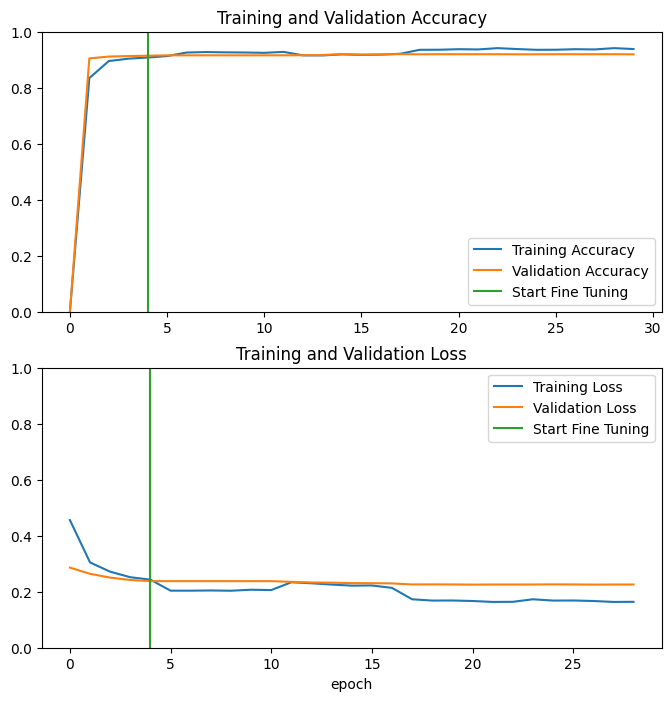

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Our model have achived 92% val accuracy now let visualize the results.........

## Results of model

In [68]:
pred_list = [f"/content/drive/MyDrive/intel image/seg_pred/seg_pred/{i}" for i in os.listdir("/content/drive/MyDrive/intel image/seg_pred/seg_pred") ]
pred_list

['/content/drive/MyDrive/intel image/seg_pred/seg_pred/7104.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7055.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7044.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7109.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7029.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7160.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7089.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7068.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7117.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7050.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7112.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7077.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7025.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7156.jpg',
 '/content/drive/MyDrive/intel image/seg_pred/seg_pred/7092.jpg',
 '/content

In [69]:
keys = [0,1,2,3,4,5]
indx_to_dict = {k: v for k ,v in zip(keys,class_names)}
indx_to_dict

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

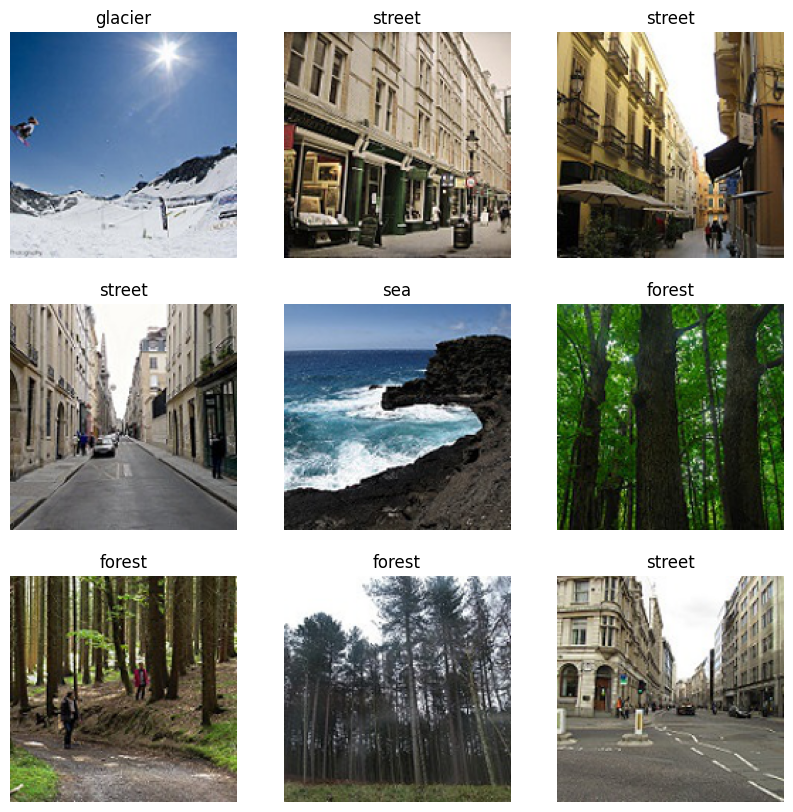

In [70]:
import random
from PIL import Image
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  num = random.randint(0,len(pred_list))
  img = Image.open(pred_list[num])
  img = img.resize((160 ,160))
  plt.imshow(img)
  img_array = np.array(img)
  img_array = img_array[np.newaxis , :]
  probability = model2(img_array)
  pred = np.argmax(probability)
  plt.title(indx_to_dict[pred])
  plt.axis("off")

    